In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-05-03 02:45:02.606122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [276]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")

vueltas.drop(['Piloto'], axis = 1, inplace = True)

In [277]:
vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020, 2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

In [278]:
#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

In [279]:
vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
#vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
#vueltas_test.drop(['Piloto'], axis = 1, inplace = True)

In [280]:
vueltas_train = vueltas_train.astype(float)
vueltas_test = vueltas_test.astype(float)

In [281]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)


In [282]:
trainX = []
trainY = []
testX = []
testY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5
                                    ])



In [283]:
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [284]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 256)           283648    
                                                                 
 dropout_14 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_15 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 480,897
Trainable params: 480,897
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
58/58 [==============================] - 5s 49ms/step - loss: 0.0326 - val_loss: 0.0309
Epoch 2/12
58/58 [==============================] - 2s 42ms/step - loss: 0.0151 - val_loss: 0.0265
Epoch 3/12
58/58 [==============================] - 2s 42ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 4/12
58/58 [==============================] - 2s 43ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 5/12
58/58 [==============================] - 3s 48ms/step - loss: 0.0100 - val_loss: 0.0128
Epoch 6/12
58/58 [==============================] - 3s 48ms/step - loss: 0.0096 - val_loss: 0.0149
Epoch 7/12
58/58 [==============================] - 3s 49ms/step - loss: 0.0101 - val_loss: 0.0124
Epoch 8/12
58/58 [==============================] - 3s 47ms/step - loss: 0.0087 - val_loss: 0.0129
Epoch 9/12
58/58 [==============================] - 3s 43ms/step - loss: 0.0087 - val_loss: 0.0119
Epoch 10/12
58/58 [==============================] - 2s 41ms/step - loss: 0.0084 - val_loss: 0.0116
Epoch 11/

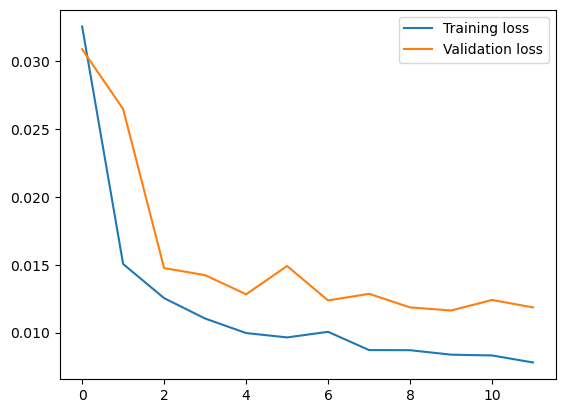

In [285]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Sacar métricas de lo que falla. Con el unique, ver a cual se acerca más. Sacar matrix_confusion, con este modelo.

### Ahora vamos a sacar todas las Y^ y todas las y.

In [286]:
y_real = testY.tolist()

In [287]:
y_pred = model.predict(testX)  

34/34 [==============================] - 1s 11ms/step


In [288]:
#Predecimos con los datos de entrenamiento, solo queremos sacar los puntos
predictions = model.predict(trainX)


128/128 [==============================] - 1s 10ms/step


In [289]:
clases = np.unique(trainY[:,0])


### Vamos a sacar los puntos que mejor separan las clases, y para ello vamos a usar una regresion logistica

In [290]:
puntos = []

In [291]:
trainY_ = np.copy(trainY)
index0 = trainY_[:,0] == clases[0]
index1 = np.logical_or(trainY_[:,0] == clases[1],trainY_[:,0] == clases[2], trainY_[:,0] == clases[3])
trainY_[index0] = 1
trainY_[index1] = 0

predictions = np.squeeze(predictions)
predictions = predictions.reshape(-1,1)
predictions.shape

trainY_ = np.squeeze(trainY_)
trainY_ = trainY_.reshape(-1,1)

rl = LogisticRegression(random_state=0).fit(predictions, trainY_)
punto = -rl.intercept_/rl.coef_
puntos.append(punto)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [292]:
from sklearn.linear_model import LogisticRegression
##Este calcula el punto entre la clase 2 y la 3
trainY_ = np.copy(trainY)
index0 = np.logical_or(trainY_[:,0] == clases[0],trainY_[:,0] == clases[1] )
index1 = np.logical_or(trainY_[:,0] == clases[2],trainY_[:,0] == clases[3] )
trainY_[index0] = 0
trainY_[index1] = 1

predictions = np.squeeze(predictions)
predictions = predictions.reshape(-1,1)
predictions.shape

trainY_ = np.squeeze(trainY_)
trainY_ = trainY_.reshape(-1,1)

rl = LogisticRegression(random_state=0).fit(predictions, trainY_)
punto = -rl.intercept_/rl.coef_
puntos.append(punto)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [293]:
trainY_ = np.copy(trainY)
index0 = trainY_[:,0] != clases[3]
index1 = trainY_[:,0] == clases[3]
trainY_[index0] = 0
trainY_[index1] = 1

predictions = np.squeeze(predictions)
predictions = predictions.reshape(-1,1)

trainY_ = np.squeeze(trainY_)
trainY_ = trainY_.reshape(-1,1)

rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, trainY_)
punto = -rl.intercept_/rl.coef_
puntos.append(punto)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [294]:
uniques = set(tuple(x) for x in y_real)
uniques = [list(x) for x in uniques]

In [295]:
#Esto es cogiendo el punto medio entre las dos clases con regresion logistica
y_pred_normalized_rl = [] 
for val in y_pred:
    if (val<puntos[0][0][0]):
        y_pred_normalized_rl.append(uniques[0][0])
    if (val>=puntos[0][0][0] and val<puntos[1][0][0]):
        y_pred_normalized_rl.append(uniques[3][0])
    if (val>=puntos[1][0][0] and val<puntos[2][0][0]):
        y_pred_normalized_rl.append(uniques[3][0])
    if (val>=puntos[2][0][0]):
        y_pred_normalized_rl.append(uniques[2][0])


In [296]:
#Esto es cogiendo el punto medio
y_pred_normalized_wrl = []
for val in y_pred:
    dist = [abs(val-x[0]) for x in uniques]
    closest_val = uniques[np.argmin(dist)][0]
    y_pred_normalized_wrl.append(closest_val)

In [297]:
bien_predecidas = 0
mal_predecidas = 0

for i in range (0, len(y_real)):
    if y_pred_normalized_rl[i] == y_real[i][0]:
        bien_predecidas += 1
    else:
        mal_predecidas += 1

precision_rl = bien_predecidas/(mal_predecidas+bien_predecidas)      

In [298]:
print("El modelo con rl tiene una precision de: ", precision_rl)

El modelo con rl tiene una precision de:  0.3975563909774436


In [299]:
bien_predecidas = 0
mal_predecidas = 0

for i in range (0, len(y_real)):
    if y_pred_normalized_wrl[i] == y_real[i][0]:
        bien_predecidas += 1
    else:
        mal_predecidas += 1

precision_wrl = bien_predecidas/(mal_predecidas+bien_predecidas)   

In [300]:
print("El modelo sin rl tiene una precision de: ", precision_wrl)

El modelo sin rl tiene una precision de:  0.5281954887218046


### Ahora tenemos que sacar las demás métricas y como tenemos 4 clases

### El número de stint que más veces aparece en el conjunto de test, ¿qué porcentaje sobre el total supone? 

In [301]:
clases = [str(sublista[0]) for sublista in uniques]

### Ahora tenemos la lista clases, que son nuestras 4 clases para clasificar. Asi que vamos a pasar las clases a string, y vamos a sacar FN, FP, TP, TN

In [312]:
y_real_ = [sublista[0] for sublista in y_real]

In [313]:
y_real_str = [str(sublista) for sublista in y_real_]
y_pred_normalized_str_wrl = [str(sublista) for sublista in y_pred_normalized_wrl]

In [314]:
from sklearn.metrics import confusion_matrix, classification_report
# Calcular la matriz de confusión
cm = confusion_matrix(y_real_str, y_pred_normalized_str_wrl, labels=clases)
metricas=classification_report(y_real_str, y_pred_normalized_str_wrl, labels=clases)

nombre_archivo = "ejecuciones/ejecucion_1_wrl.txt"

# Abrir el archivo en modo de escritura
with open(nombre_archivo, "w") as archivo:

    # Redirigir la salida de print() al archivo
    print("Matriz de confusión:", file=archivo)
    print(clases, file=archivo)
    print(cm, file=archivo)
    print("Métricas:", file=archivo)
    print(metricas, file=archivo)
    print("Y real:", file=archivo)
    print(y_real_str, file = archivo)
    print("Y predicho:", file=archivo)
    print(y_pred_normalized_str_wrl, file = archivo)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [315]:
y_real_str = [str(sublista) for sublista in y_real_]
y_pred_normalized_str_rl = [str(sublista) for sublista in y_pred_normalized_rl]

In [316]:
cm = confusion_matrix(y_real_str, y_pred_normalized_str_rl, labels=clases)
metricas_rl = classification_report(y_real_str, y_pred_normalized_str_rl, labels=clases)

nombre_archivo = "ejecuciones/ejecucion_1_rl.txt"

# Abrir el archivo en modo de escritura
with open(nombre_archivo, "w") as archivo:

    # Redirigir la salida de print() al archivo
    print("Matriz de confusión:", file=archivo)
    print(clases, file=archivo)
    print(cm, file=archivo)

    print("Métricas:", file=archivo)
    print(metricas_rl, file=archivo)
    print("Y real:", file=archivo)
    print(y_real_str, file = archivo)
    print("Y predicho:", file=archivo)
    print(y_pred_normalized_str_rl, file = archivo)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
